In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Just a random function to understand derivaties

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(23)

1500

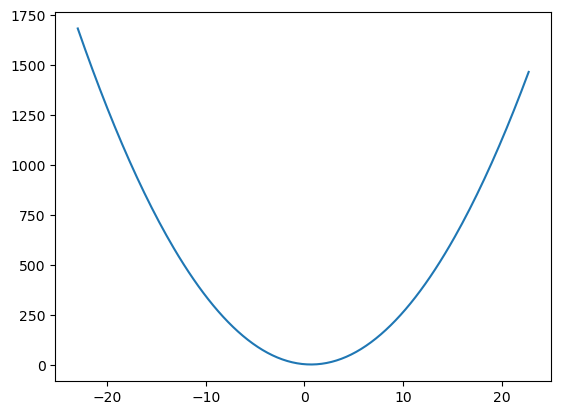

In [4]:
xs = np.arange(-23,23,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
# play around these values at,
# h with very small you end up getting 0 as float points representations will be messing up 
# eg: h =  0.000000000000000000000001 

h = 0.00000000000001 
x = 3.0
(f(x+h) - f(x))/h

14.210854715202004

In [6]:
# now lets take a bit complex example 

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.00002
slope 2.0000000000131024


In [37]:
class Value:
    
    def __init__(self, data, _children =(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda:None 
        
    # Python repr() Function returns a printable representation of an object in Python.
    # Try commenting below funtion to understand its effects
    def __repr__(self):
        return f"Value(data={self.data})"
    
    
    
    # The __add__() method in Python specifies what happens when you call + on two objects. 
    # When you call obj1 + obj2, you are essentially calling obj1.__add__(obj2).
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        
        return out
    
    
    # The Python __mul__() method is called to implement the arithmetic multiplication operation *. 
    # For example to evaluate the expression x * y, Python attempts to call x.__mul__(y).
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad # += to accumulate the gradients
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,),'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad
        
        out._backward = _backward
            
        return out
    
    def backward(self):
        
        topo = []
        visited=set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad=1.0
        for node in reversed(topo):
            node._backward()


In [10]:
a = Value(2.0, label = 'a')
b = Value(3.0,label = 'b')
c = Value(4.0,label = 'c')

print(a+b)
print(a.__add__(b))

print(a*b)
print(a.__mul__(b))

print(a*b + c)
print(a.__mul__(b).__add__(c))

d = a*b
d.label = 'd'
e = d + c
e.label = 'e'

f = Value(-3, label = 'f')
L = e* f
L.label = 'L'

print(d)
print(d._prev)
print(d._op)

Value(data=5.0)
Value(data=5.0)
Value(data=6.0)
Value(data=6.0)
Value(data=10.0)
Value(data=10.0)
Value(data=6.0)
{Value(data=3.0), Value(data=2.0)}
*


In [20]:
from graphviz import Digraph # for mac: brew install graphviz

def trace(root):
    
    # builds a set of all nodes and edges in a graph
    nodes, edges = set (), set ()
    
    def build (v):
        
        if v not in nodes:
            nodes.add(v)
            
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot (root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s| data %.4f | grad %.4f}" % (n.label,n.data, n.grad), shape='record')
                  
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
                      
    for n1, n2 in edges:
        # connect ni to the on node of n
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [11]:
draw_dot(L)

NameError: name 'L' is not defined

L = d*f

dl/dd = ? = f

(f(x+h)-f(h))/h

((d+h) * f) - d*f / h

h*f/h

f


dl/dc = ?

dl/dd * dd/ dc

d = c + e

(f(x+h)-f(h))/h 

c + h + e - c - h / h

h/h = 1.0

dd/dc = dd/de = 1

In [13]:
# Manual Backprop
def get_grads():
    
    h = 0.001
    a = Value (2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value (10.0, label='c')
    d = a*b; d.label = 'd'
    e = c+d; e.label = 'e'
    f = Value(-2.0, label='f')
    L = e * f; L. label = 'L'
    L1 = L.data
    

    a = Value (2.0, label='a')
    
    b = Value(-3.0, label='b')
    
    c = Value (10.0, label='c')
    c.data +=h
    d = a*b; d.label = 'd'
    
    e = c+d; e.label = 'e' 
    f = Value(-2.0, label='f')
    L = e * f; L. label = 'L'
    L2 = L.data
    
    print ((L2 - L1) /h)

In [14]:
get_grads()

-1.9999999999988916


In [15]:
L.grad = 1.0
e.grad = -2.0
f.grad = 4.0
c.grad = -2.0
d.grad = -2.0
a.grad = 6.0
b.grad = -4.0

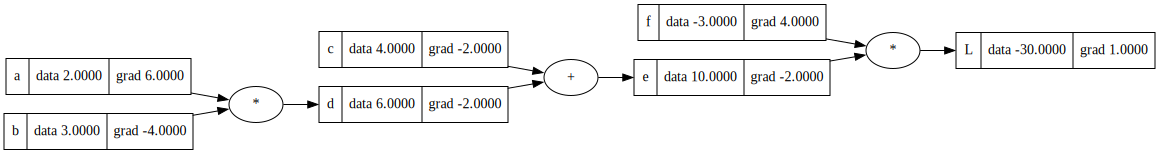

In [16]:
draw_dot(L)

In [17]:
# manual forward prop
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a * b

e = d + c

L = e * f

print(L)

Value(data=-29.829696000000002)


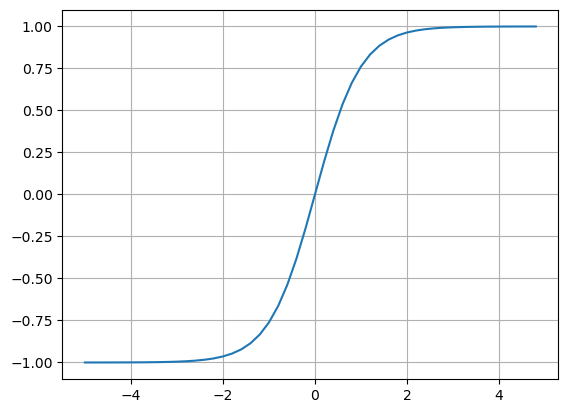

In [18]:
plt.plot(np.arange (-5,5,0.2), np.tanh(np.arange (-5,5,0.2))); plt.grid();

Understanding with neurons

In [31]:
# inputs x1,x2

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'



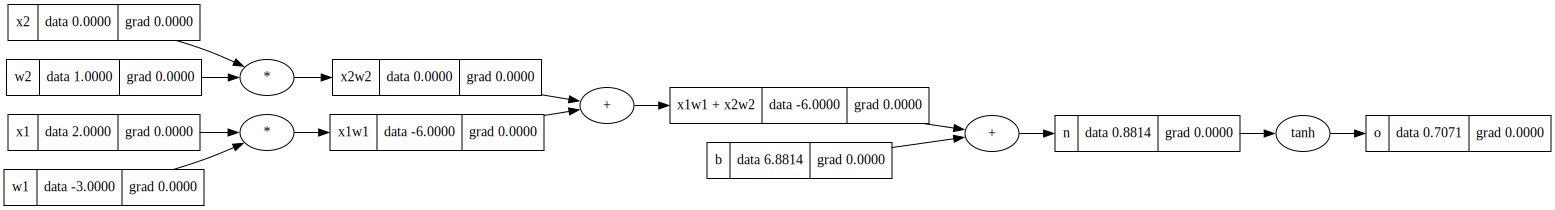

In [32]:
draw_dot(o)

In [21]:
o.grad = 1.0
n.grad = 1-o.data**2

In [22]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [23]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [24]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [25]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

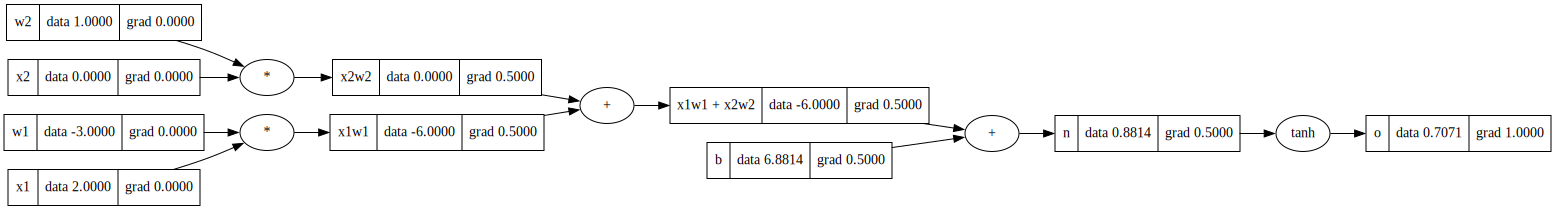

In [66]:
draw_dot(o)

In [23]:
o.grad=1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

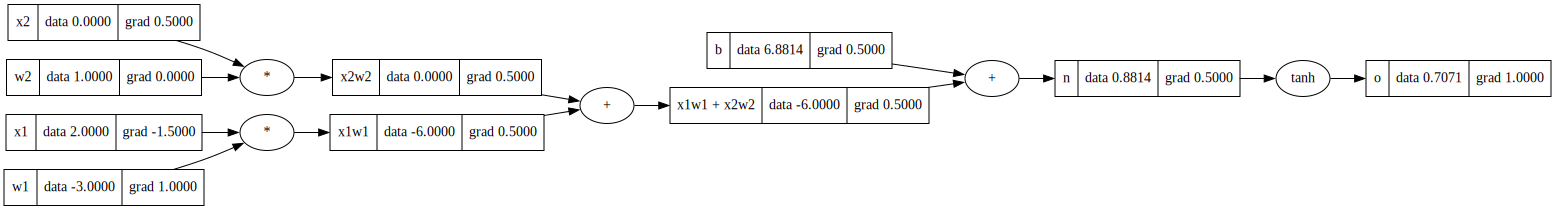

In [24]:
draw_dot(o)

In [28]:
o.grad=1.0
topo = []
visited=set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

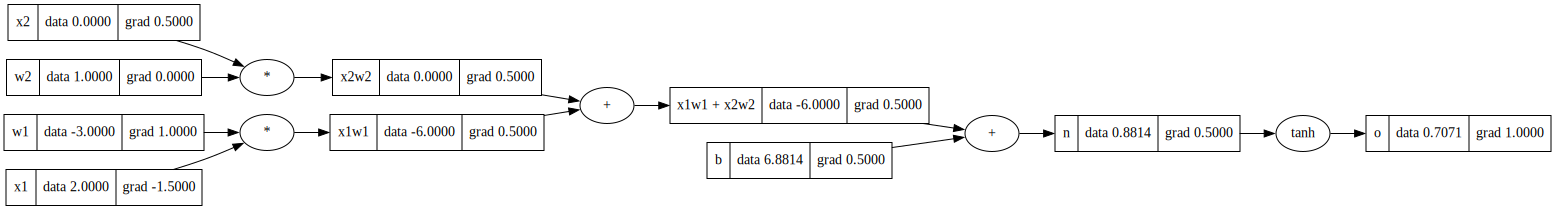

In [29]:
draw_dot(o)

In [33]:
o.backward()

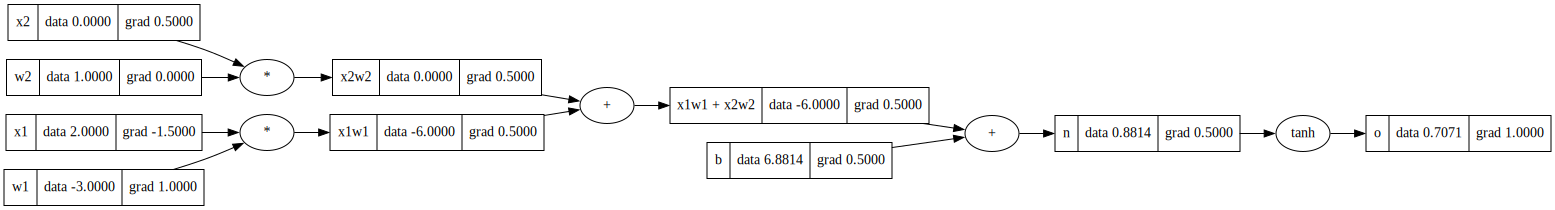

In [34]:
draw_dot(o)

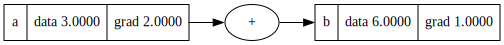

In [38]:
# bug example

a = Value(3.0,label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

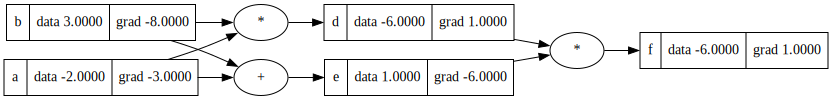

In [39]:
# bug example

a = Value(-2.0,label = 'a')
b = Value(3.0,label = 'b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)